In [1]:
from typing import List

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf

from scipy.stats import t
from scipy.stats import chi2
from scipy.stats import pearsonr

from pingouin import multivariate_normality

from itertools import combinations

from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.diagnostic import lilliefors

from sklearn.linear_model import LinearRegression

class bcolors:
    HEADER = '\033[95m'
    OKBLUE = '\033[94m'
    OKGREEN = '\033[92m'
    WARNING = '\033[93m'
    FAIL = '\033[91m'
    ENDC = '\033[0m'


In [2]:
df = pd.read_csv('data/ANOVA_01_2026-01-27_B.csv')

In [3]:
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  100 non-null    int64  
 1   Index       100 non-null    int64  
 2   X_1         100 non-null    float64
 3   X_2         100 non-null    float64
 4   X_3         100 non-null    float64
 5   X_4         100 non-null    float64
dtypes: float64(4), int64(2)
memory usage: 4.8 KB


In [4]:
df.drop('Unnamed: 0', axis=1, inplace=True)
df.describe()

,Index,X_1,X_2,X_3,X_4
count,100.000000,100.000000,100.000000,100.000000,100.000000
mean,50.500000,0.791790,0.782639,0.829316,0.802692
std,29.011492,0.331912,0.335075,0.327502,0.350614
min,1.000000,0.043293,-0.281425,-0.022263,0.114507
25%,25.750000,0.555926,0.565193,0.625905,0.583083
50%,50.500000,0.821644,0.840238,0.846239,0.748333
75%,75.250000,1.006917,1.008533,1.054503,1.035575
max,100.000000,1.551541,1.433671,1.605139,1.648295


In [5]:
columns = df.columns[1:]

# Stazionarietà del Processo
[N.B. È nel nostro interesse avere delle rassicurazioni sul fatto che il processo sia stazionario in media e varianza (i valori non cambiano nel tempo]
1. **Perché effettuare la regressione tra l'indice (var. indipendente) e le componenti del dataset (var. dipendente?**
2. **Come interpretare la retta di regressione?**
3. **Cos'è la LOESS?**
4. **Cosa significa che la retta di regressione presenta un trend?**
5. **Cosa significa che la LOESS si discosta dalla retta di regressione?**

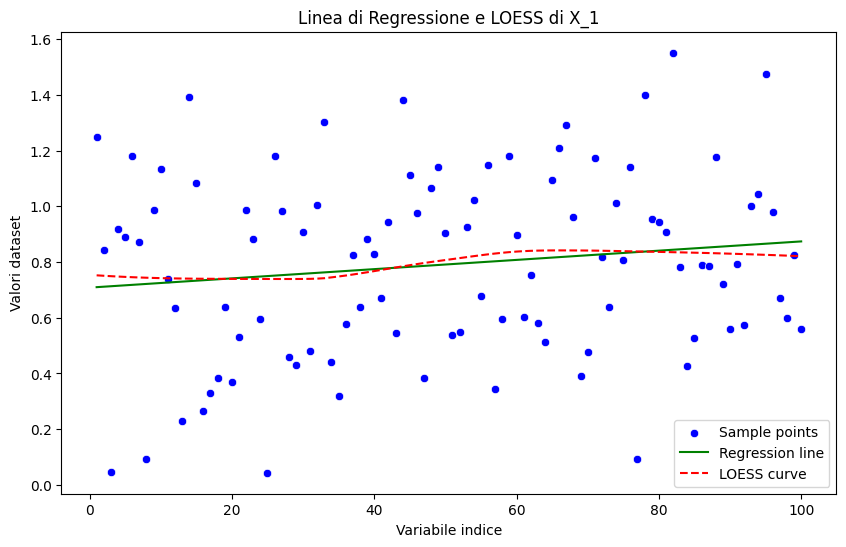

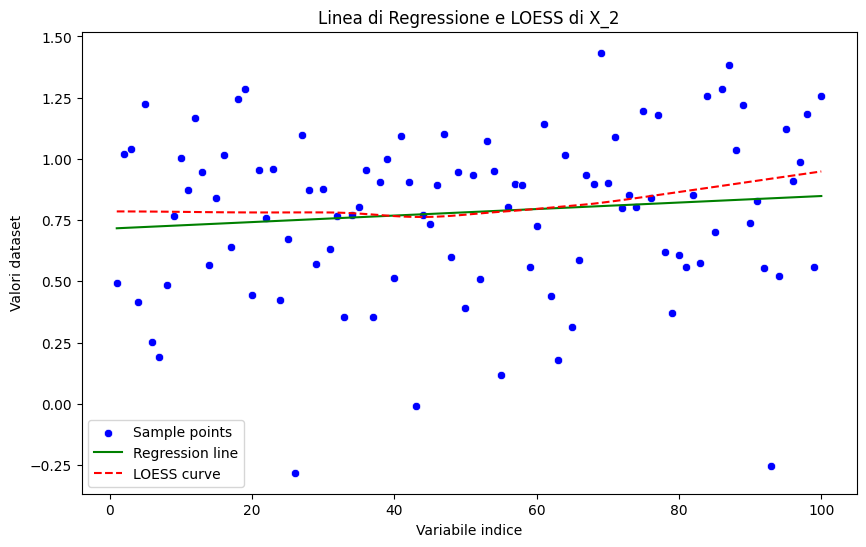

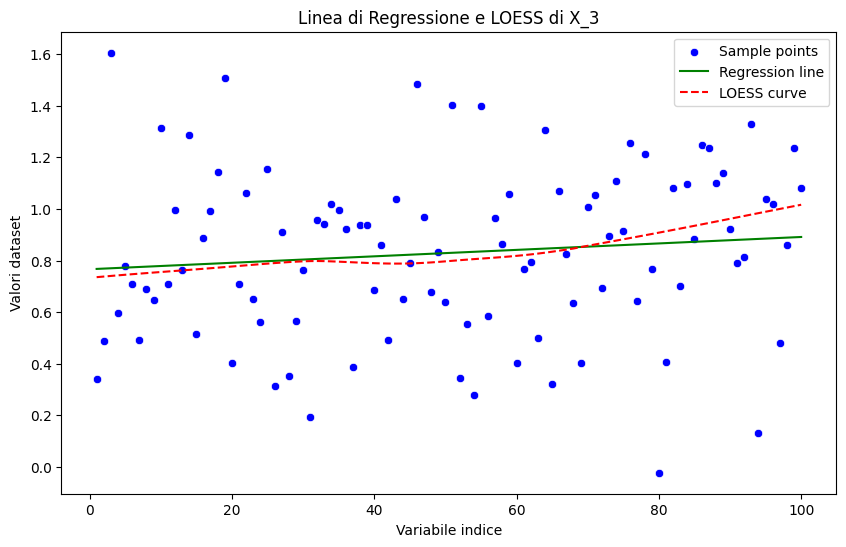

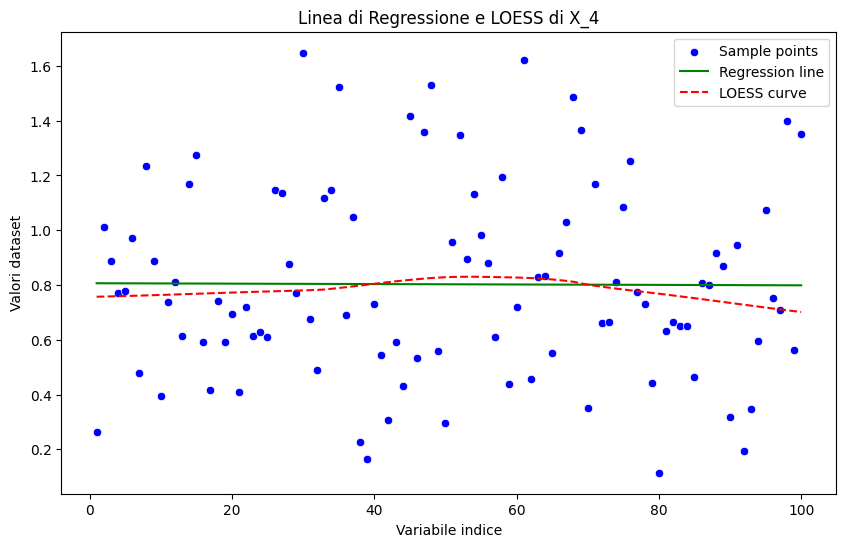

In [6]:
def plot_regression_loess(data, col, index_col='Index'):
        x = data[[index_col]].values.reshape(-1, 1)
        y = data[col].values

        model = LinearRegression().fit(x, y)
        y_pred = model.predict(x)

        lowess = sm.nonparametric.lowess
        loess_smoothed = lowess(y, data[index_col])

        plt.figure(figsize = (10, 6))
        sns.scatterplot(x=index_col, y=col, data=data, color='blue', label='Sample points')
        plt.plot(data[index_col], y_pred, color='green', label='Regression line')
        plt.plot(data[index_col], loess_smoothed[:, 1], color='red', label='LOESS curve', linestyle='--')

        plt.title(f'Linea di Regressione e LOESS di {col}')
        plt.xlabel('Variabile indice')
        plt.ylabel('Valori dataset')
        plt.legend()
        plt.show()

for col in columns:
    plot_regression_loess(df, col)

# Indipendenza

Si vogliono avere delle rassicurazioni sul fatto che non esistano relazioni di correlazione significative tra le osservazioni di un campione e tra i diversi gruppi.

## Autocorrelazione

In [7]:
def calculate_max_lag(n: int):
    return min(10, n // 4)

In [8]:
def confidence_bound(alpha: float, n: int) -> float:
    if alpha < 0 or alpha > 1:
        raise ValueError('alpha must be between 0 and 1')
    return stats.norm.ppf(1 - alpha / 2) / np.sqrt(n)

In [9]:
def tolerance_rules(levels: List[float], max_lag: int, n: int) -> dict:
    levels.sort(reverse=True)
    styles = ['--', '-.', ':', '-']
    colors = ['green', 'orange', 'red', 'blue', 'orange']
    rules = {}
    for (i, l) in enumerate(levels):
        key = f'{int((1-l)*100)}%'
        rules[key] = {
            'z': confidence_bound(l, n),
            'allowed': int(np.floor(max_lag * l)),
            'color': colors[i % len(colors)],
            'style': styles[i % len(styles)],
        }
    return rules

In [10]:
import matplotlib.pyplot as plt
import statsmodels.api as sm
import numpy as np

def generic_acf_pacf_plot(
        values,
        max_lag: int,
        rules: dict,
        title: str,
        col_name: str,
        y_lbl: str
):
    print(f'{bcolors.HEADER}\n--- {col_name} ---{bcolors.ENDC}')
    plt.figure(figsize=(10, 6))
    plt.title(title)
    plt.stem(range(1, max_lag + 1), values, linefmt='k-', markerfmt='kD', basefmt=" ")

    for label, params in rules.items():
        limit = params['z']
        count = np.sum(np.abs(values) > limit)
        status = 'PASS' if count <= params['allowed'] else 'FAIL'
        plt.axhline(y=limit, color=params['color'], linestyle=params['style'], label=f'{label} (Allow {params["allowed"]})')
        plt.axhline(y=-limit, color=params['color'], linestyle=params['style'])
        plt.text(max_lag, limit + 0.01, f"{status}", color=params['color'], fontweight='bold')

        pretty_status = f'{bcolors.OKGREEN}PASS{bcolors.ENDC}' if count <= params['allowed'] else f'{bcolors.FAIL}FAIL{bcolors.ENDC}'
        print(f"{label} CI: {count} points outside (Allowed: {params['allowed']}) -> {pretty_status}")
    plt.xlabel('Lag')
    plt.ylabel(y_lbl)
    plt.legend(loc='lower right')
    plt.grid(True, alpha=0.3)
    plt.show()


La **tolleranza rigorosa** per i picchi è:
- $\alpha=0.10$: $\lfloor (\text{maxlag}\cdot 0.10  \rfloor = \lfloor (10\cdot 0.10  \rfloor = 1$
- $\alpha=0.05$: $\lfloor (\text{maxlag}\cdot 0.05  \rfloor = \lfloor (10\cdot 0.05  \rfloor = 0$
- $\alpha=0.01$: $\lfloor (\text{maxlag}\cdot 0.01  \rfloor = \lfloor (10\cdot 0.01  \rfloor = 0$


--- X_1 ---
90% CI: 1 points outside (Allowed: 1) -> PASS
95% CI: 1 points outside (Allowed: 0) -> FAIL
99% CI: 0 points outside (Allowed: 0) -> PASS


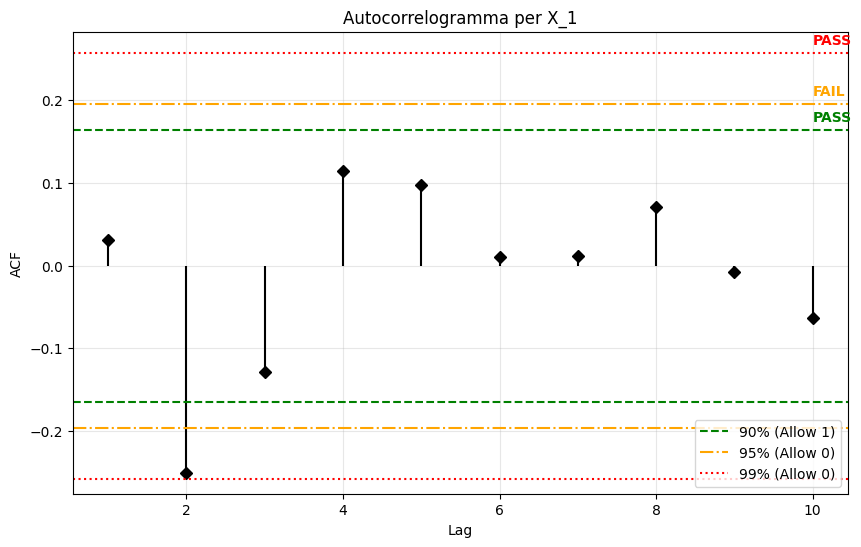


--- X_2 ---
90% CI: 1 points outside (Allowed: 1) -> PASS
95% CI: 0 points outside (Allowed: 0) -> PASS
99% CI: 0 points outside (Allowed: 0) -> PASS


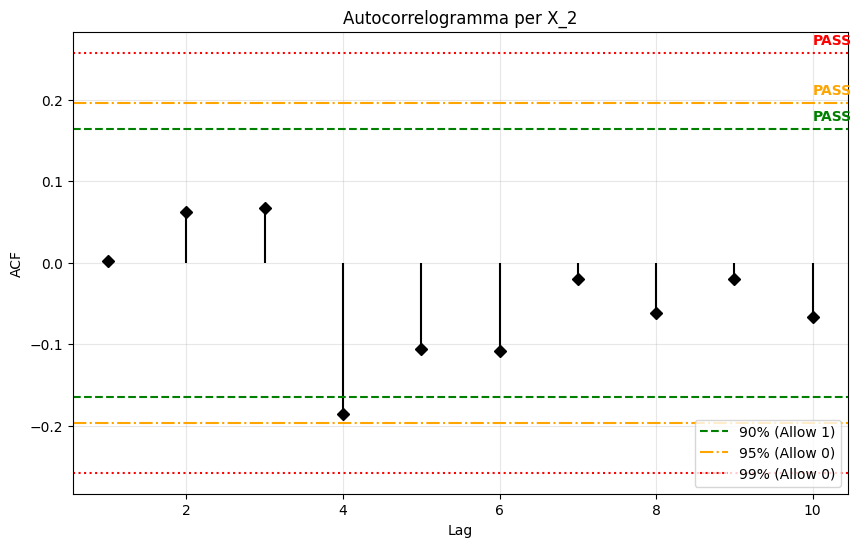


--- X_3 ---
90% CI: 2 points outside (Allowed: 1) -> FAIL
95% CI: 0 points outside (Allowed: 0) -> PASS
99% CI: 0 points outside (Allowed: 0) -> PASS


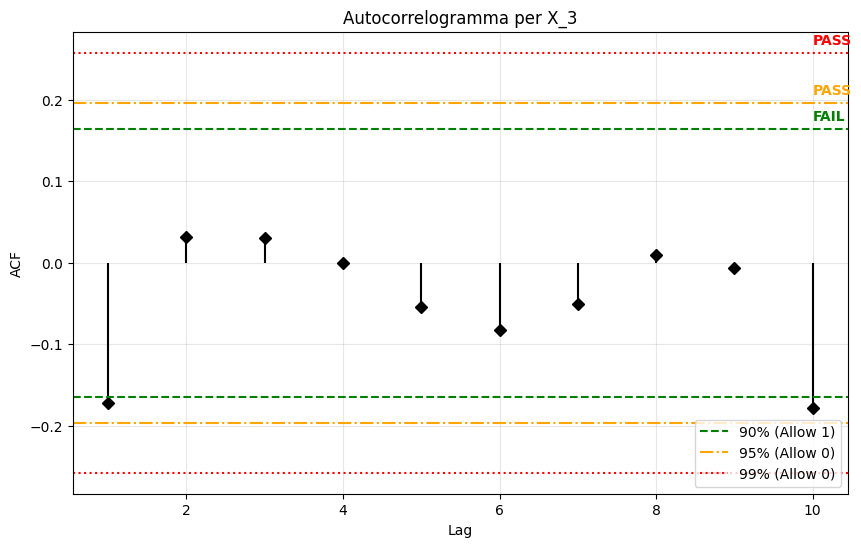


--- X_4 ---
90% CI: 0 points outside (Allowed: 1) -> PASS
95% CI: 0 points outside (Allowed: 0) -> PASS
99% CI: 0 points outside (Allowed: 0) -> PASS


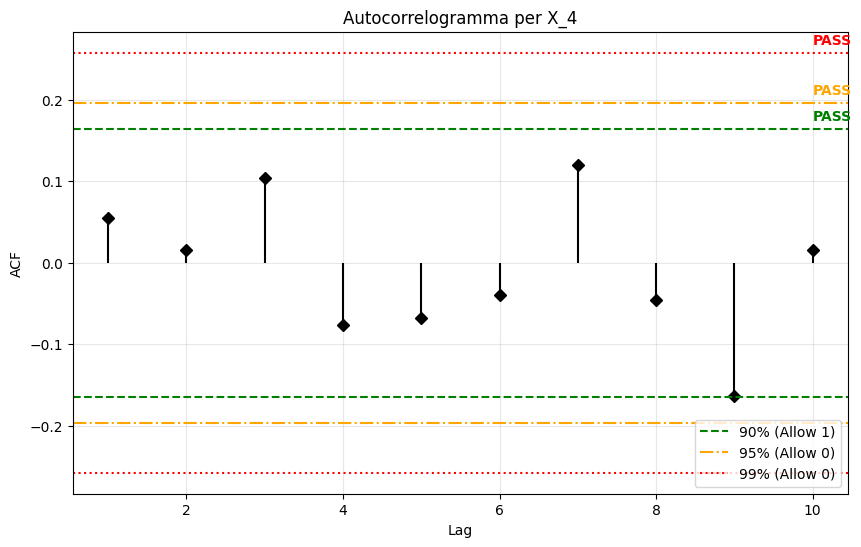

In [11]:
def acf_plot(col, max_lag: int, levels: List[float], col_name: str='Unknown'):
    rules = tolerance_rules(levels, max_lag, len(col))
    acf_values = sm.tsa.acf(col, nlags=max_lag, fft=False)
    acf_values = acf_values[1:]
    generic_acf_pacf_plot(acf_values, max_lag, rules, f'Autocorrelogramma per {col_name}', col_name, 'ACF')


for col in columns:
    acf_plot(df[col], calculate_max_lag(len(df[col])), [0.1, 0.05, 0.01], col)

## Autocorrelazione Parziale


--- X_1 ---
90% CI: 1 points outside (Allowed: 1) -> PASS
95% CI: 1 points outside (Allowed: 0) -> FAIL
99% CI: 0 points outside (Allowed: 0) -> PASS


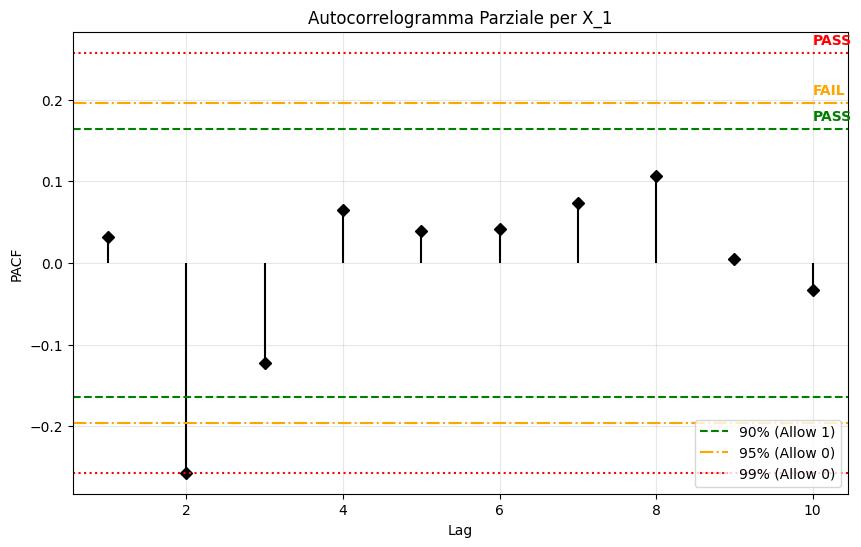


--- X_2 ---
90% CI: 1 points outside (Allowed: 1) -> PASS
95% CI: 1 points outside (Allowed: 0) -> FAIL
99% CI: 0 points outside (Allowed: 0) -> PASS


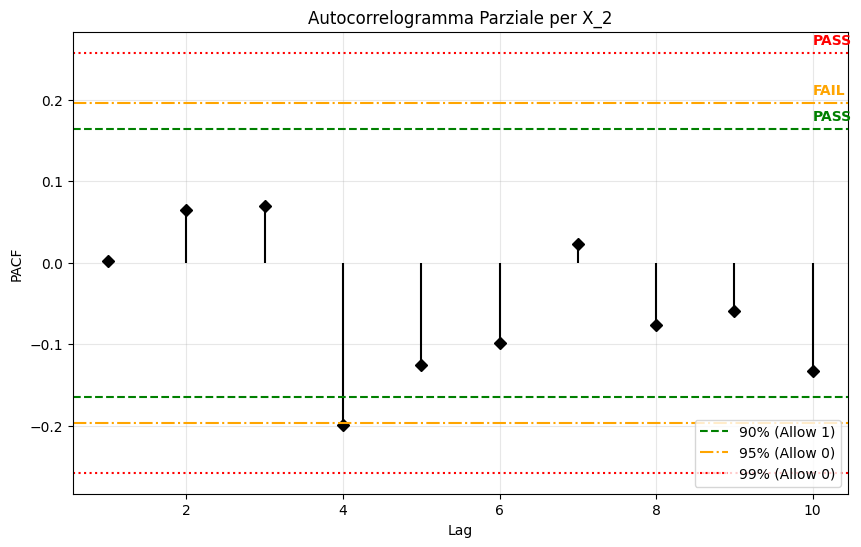


--- X_3 ---
90% CI: 2 points outside (Allowed: 1) -> FAIL
95% CI: 1 points outside (Allowed: 0) -> FAIL
99% CI: 0 points outside (Allowed: 0) -> PASS


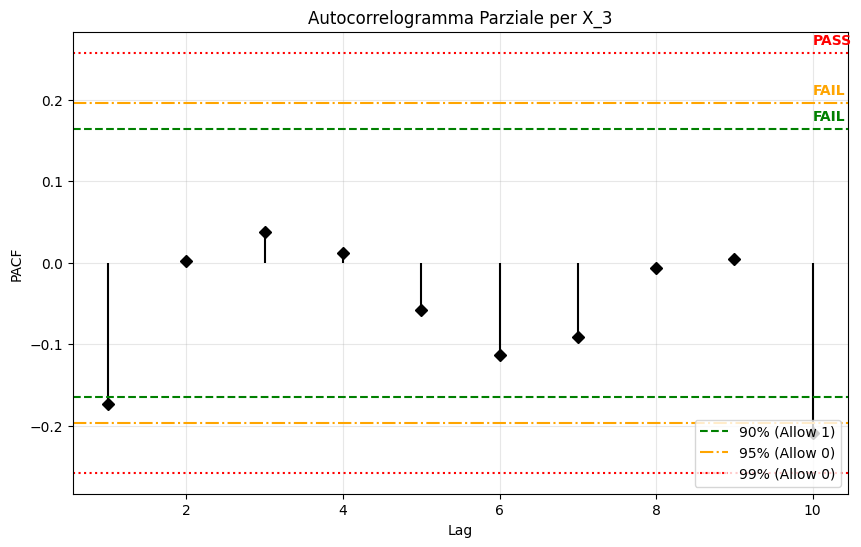


--- X_4 ---
90% CI: 1 points outside (Allowed: 1) -> PASS
95% CI: 0 points outside (Allowed: 0) -> PASS
99% CI: 0 points outside (Allowed: 0) -> PASS


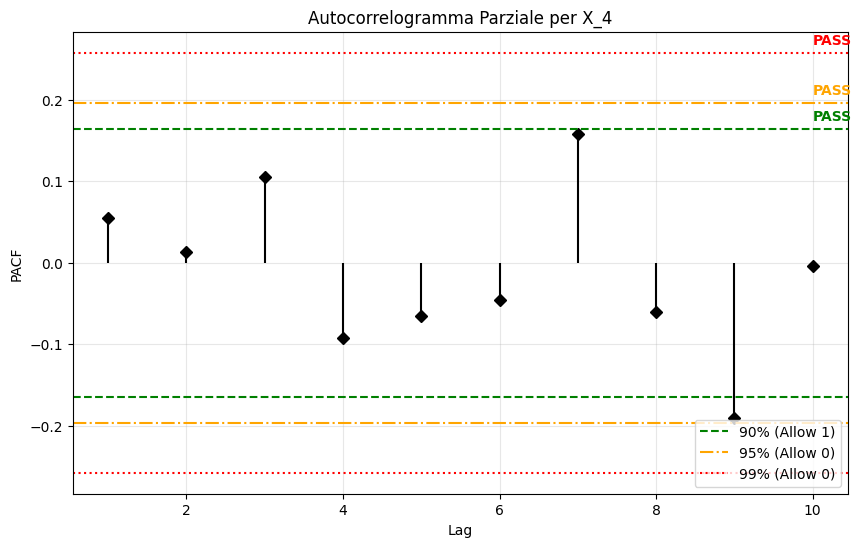

In [12]:
def pacf_plot(col, max_lag: int, levels: List[float], col_name: str='Unknown'):
    rules = tolerance_rules(levels, max_lag, len(col))
    pacf_values = sm.tsa.pacf(col, nlags=max_lag)
    pacf_values = pacf_values[1:]
    generic_acf_pacf_plot(pacf_values, max_lag, rules, f'Autocorrelogramma Parziale per {col_name}', col_name, 'PACF')


for col in columns:
    pacf_plot(df[col], calculate_max_lag(len(df[col])), [0.1, 0.05, 0.01], col)

## Test di Ljung-Box
Questo test assume come **ipotesi nulla** che non ci sia autocorrelazione fino al lag specificato.

In [13]:
def ljungbox_test(group, alpha: float):
    if alpha < 0 or alpha > 1:
        raise ValueError('alpha must be between 0 and 1')
    n = len(group)
    max_lag = min(10, n // 4)
    fit_df = 0
    lb_result = sm.stats.acorr_ljungbox(group, lags = max_lag, return_df = True, model_df = fit_df)

    print(f"Ljung-Box test for {col} (max_lag={max_lag}):")
    print(lb_result)
    print()
    failed_lags = list(filter(lambda p: p < alpha, lb_result['lb_pvalue']))
    if len(failed_lags) > 0:
        print(f'{bcolors.WARNING}it seems that for some lags {','.join(failed_lags)} p-value < {alpha}{bcolors.ENDC}')
    else:
        print(f'{bcolors.OKGREEN}All p-values are greater than {alpha}{bcolors.ENDC}')

for col in columns:
    ljungbox_test(df[col], alpha=0.01)

Ljung-Box test for X_1 (max_lag=10):
      lb_stat  lb_pvalue
1    0.099322   0.752645
2    6.629320   0.036346
3    8.367622   0.038995
4    9.764863   0.044580
5   10.776255   0.056001
6   10.788740   0.095129
7   10.802951   0.147448
8   11.359590   0.182145
9   11.366580   0.251416
10  11.827453   0.296770

All p-values are greater than 0.01
Ljung-Box test for X_2 (max_lag=10):
     lb_stat  lb_pvalue
1   0.000291   0.986387
2   0.410471   0.814455
3   0.891483   0.827483
4   4.546605   0.337057
5   5.762752   0.329993
6   7.025405   0.318504
7   7.067244   0.421912
8   7.484406   0.485380
9   7.529912   0.582122
10  8.033013   0.625612

All p-values are greater than 0.01
Ljung-Box test for X_3 (max_lag=10):
     lb_stat  lb_pvalue
1   3.034324   0.081521
2   3.135322   0.208532
3   3.230550   0.357426
4   3.230564   0.520008
5   3.544006   0.616740
6   4.279796   0.638870
7   4.560532   0.713416
8   4.570098   0.802380
9   4.575483   0.869635
10  8.178475   0.611409

All p-values 

Poiché tutti i p-value per le variabili del test di Ljung-Box sono maggiori di α=0.01, non abbiamo evidenza statistica sufficiente per rifiutare l'ipotesi nulla di assenza di autocorrelazione fino al lag specificato.

Ovviamente, sottolineiamo ancora come il test non conferma la scorrelazione, ma piuttosto che non c'è evidenza sufficiente per dimostrare il contrario (come detto più volte a lezione: l'assenza di prove a un processo non implica necessariamente innocenza).

Dunque, non possiamo rifiutare l'ipotesi nulla: i dati non sono autocorrelati e potrebbero essere stati generati in modo indipendente.

## Cross-Correlazione

### Matrice di Varianza-Covarianza
**TODO: QUALI VALORI SONO CONSIDERATI ALTI??**

In [14]:
def calculate_cov_matrix(df, columns):
    cov_matrix = df[columns].cov()
    return cov_matrix

cov_matrix = calculate_cov_matrix(df, columns)
print(cov_matrix)

          X_1       X_2       X_3       X_4
X_1  0.110166 -0.021406 -0.005518  0.001721
X_2 -0.021406  0.112275  0.029388  0.023079
X_3 -0.005518  0.029388  0.107258  0.000780
X_4  0.001721  0.023079  0.000780  0.122930


### Matrice di cross-correlazione
**TODO:** CHIEDERE QUALI VALORI SONO CONSIDERATI ALTI?

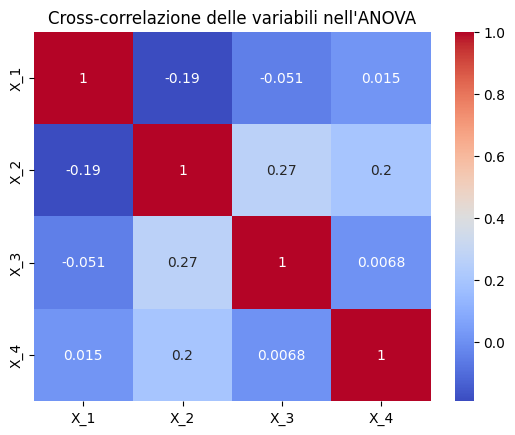

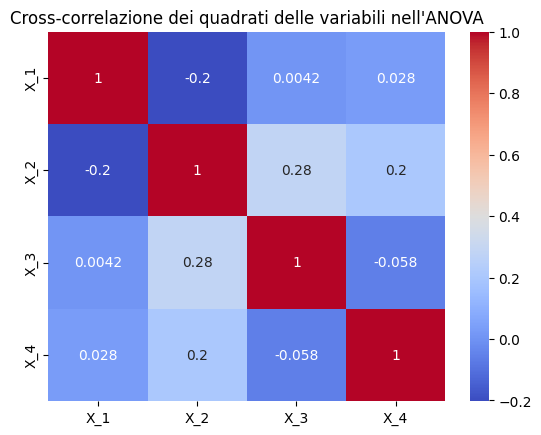

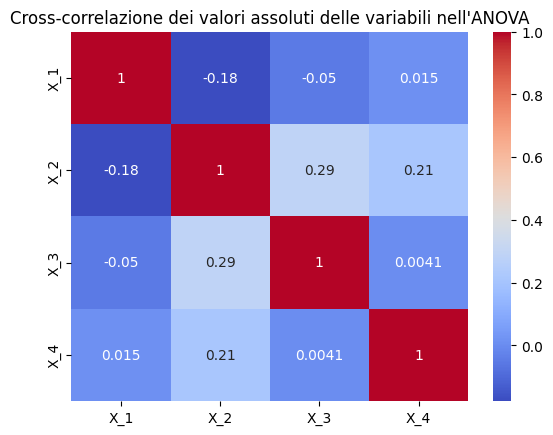

In [15]:
def plot_corr_heatmap(data, title):
    corr_matrix = data.corr()
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
    plt.title(title)
    plt.show()

plot_corr_heatmap(df.drop(columns='Index'), "Cross-correlazione delle variabili nell'ANOVA")

squared_df = df.drop(columns='Index') ** 2
plot_corr_heatmap(squared_df, "Cross-correlazione dei quadrati delle variabili nell'ANOVA")

abs_df = df.drop(columns='Index').abs()
plot_corr_heatmap(abs_df, "Cross-correlazione dei valori assoluti delle variabili nell'ANOVA")

### Test di Pearson
Il test di Pearson misura la forza della relazione lineare tra due variabili, fornendo coefficiente di correlazione r e p-value associato (si limita a relazioni lineari e potrebbe non rilevare correlazioni non lineari). Ha come:
- $H_0:$ la distribuzione delle variabili SONO non correlate e normalmente distribuite
- $H_1:$ la distribuzione delle variabili NON non correlate e normalmente distribuite

In [16]:
def pearson_corr(data, alpha = 0.10):
    for col1, col2 in combinations(columns, 2):
        corr_coeff, p_value = pearsonr(df[col1], data[col2])

        print(f"Pearson correlation between {col1} and {col2}")
        print(f"Correlation coefficient: {corr_coeff}")
        print(f"P-value: {p_value}")

        if p_value > alpha:
            print(f"\033[1m** Conclusione: p-value > {alpha} **\n[{col1}; {col2}] Non rifiutiamo l'ipotesi nulla al livello di significatività del {int(alpha * 100)}% -> Le variabili SONO non correlate e normalmente distribuite. \033[0m")
        else:
            print(f"\033[1m** Conclusione: p-value <= {alpha} **\n[{col1}; {col2}] Rifiutiamo l'ipotesi nulla al livello di significatività del {int(alpha * 100)}% -> Le variabili NON sono non correlate e normalmente distribuite. \033[0m")

        print()

pearson_corr(df, alpha = 0.01)

Pearson correlation between X_1 and X_2
Correlation coefficient: -0.19247551013395298
P-value: 0.0550430786834985
** Conclusione: p-value > 0.01 **
[X_1; X_2] Non rifiutiamo l'ipotesi nulla al livello di significatività del 1% -> Le variabili SONO non correlate e normalmente distribuite. 

Pearson correlation between X_1 and X_3
Correlation coefficient: -0.05076322689143011
P-value: 0.6159674620787187
** Conclusione: p-value > 0.01 **
[X_1; X_3] Non rifiutiamo l'ipotesi nulla al livello di significatività del 1% -> Le variabili SONO non correlate e normalmente distribuite. 

Pearson correlation between X_1 and X_4
Correlation coefficient: 0.014785122368854691
P-value: 0.8839211264544019
** Conclusione: p-value > 0.01 **
[X_1; X_4] Non rifiutiamo l'ipotesi nulla al livello di significatività del 1% -> Le variabili SONO non correlate e normalmente distribuite. 

Pearson correlation between X_2 and X_3
Correlation coefficient: 0.2677980104857513
P-value: 0.0070663944943846506
** Conclusio

### Likelihood Ratio Test
Il test LR confronta un modello completo (che include tutte le variabili di interesse) e un modello ridotto (che include solo una parte di esse). In particolare, confronta la log-verosimiglianza dei due modelli. Ha come:
- $H_0:$ Le matrici di covarianza del modello completo e del modello ridotto SONO uguali
- $H_1:$ Le matrici di covarianza del modello completo e del modello ridotto NON sono uguali

In [17]:
def lr_test(data, alpha = 0.10):
    n, p = data.shape

    cov_matrix_full = np.cov(df, rowvar = False)
    cov_matrix_reduced = np.diag(np.diag(cov_matrix_full))

    log_likelihood_full = -n * (p / 2) * np.log(2 * np.pi) - n / 2 * np.log(np.linalg.det(cov_matrix_full)) - n / 2 * np.trace(np.dot(np.linalg.inv(cov_matrix_full), cov_matrix_full))
    log_likelihood_reduced = -n * (p / 2) * np.log(2 * np.pi) - n / 2 * np.log(np.linalg.det(cov_matrix_reduced)) - n / 2 * np.trace(np.dot(np.linalg.inv(cov_matrix_reduced), cov_matrix_full))

    lr_stat = 2 * (log_likelihood_full - log_likelihood_reduced)

    data = p * (p - 1) /2
    p_value = 1 - chi2.cdf(lr_stat, data)

    print(f"Likelihood ratio test")
    print(f"Test statistic: {lr_stat}")
    print(f"P-value: {p_value}")

    if p_value > alpha:
        print(f"\033[1m** Conclusione: p-value > {alpha} **\nNon rifiutiamo l'ipotesi nulla al livello di significatività del {int(alpha * 100)}% -> le matrici di covarianza del modello completo e del modello ridotto SONO uguali. \033[0m")
    else:
        print(f"\033[1m** Conclusione: p-value <= {alpha} **\nRifiutiamo l'ipotesi nulla al livello di significatività del {int(alpha * 100)}% -> le matrici di covarianza del modello completo e del modello ridotto NON sono uguali. \033[0m")

lr_test(df, alpha = 0.01)

Likelihood ratio test
Test statistic: 20.856830232000902
P-value: 0.022114316702599557
** Conclusione: p-value > 0.01 **
Non rifiutiamo l'ipotesi nulla al livello di significatività del 1% -> le matrici di covarianza del modello completo e del modello ridotto SONO uguali. 


# Test di Normalità

## Shapiro-Wilk Test

Questo test è uno dei più potenti per la verifica della normalità, specialmente con campioni piccoli o medi. È molto sensibile a deviazioni dalla normalità sia nelle code che nella parte centrale della distribuzione. Ha come:
- $H_0:$ i dati PROVENGONO da una distribuzione normale
- $H_1:$ i dati NON provengono da una distribuzione normale

In [18]:
def shapiro_wilk_test(group, alpha: float, col_name: str):
    stat, p = stats.shapiro(group)

    print(f'{bcolors.HEADER}Test di Shapiro-Wilk per {col_name}{bcolors.ENDC}')
    print(f'stat: {stat}, p-value: {p}')

    if p < alpha:
        print(f'{bcolors.FAIL}L\'ipotesi nulla viene rigettata con livello di significatività {int(alpha * 100)}%{bcolors.ENDC}')
    else:
        print(f'{bcolors.OKGREEN}L\'ipotesi nulla viene accettata con livello di significatività {int(alpha * 100)}%{bcolors.ENDC}')
    print()

for col in columns:
    shapiro_wilk_test(df[col], alpha=0.01, col_name=col)

Test di Shapiro-Wilk per X_1
stat: 0.9897098143740144, p-value: 0.6411645016328533
L'ipotesi nulla viene accettata con livello di significatività 1%

Test di Shapiro-Wilk per X_2
stat: 0.9673964925014231, p-value: 0.014020264221820029
L'ipotesi nulla viene accettata con livello di significatività 1%

Test di Shapiro-Wilk per X_3
stat: 0.9953822877586794, p-value: 0.9837876526316345
L'ipotesi nulla viene accettata con livello di significatività 1%

Test di Shapiro-Wilk per X_4
stat: 0.9773099970891778, p-value: 0.08187508489384335
L'ipotesi nulla viene accettata con livello di significatività 1%



## Test di D'Agostino-Pearson
- $H_0:$ i dati PROVENGONO da una distribuzione normale,
- $H_1:$ i dati NON provengono da una distribuzione normale.


In [19]:
def dagostino_pearson_test(group, alpha: float, col_name: str):
    stat, pvalue = stats.normaltest(group)

    print(f'{bcolors.HEADER}Test di D\'Agostino-Pearson per {col_name}{bcolors.ENDC}')
    print(f'stat: {stat}, p-value: {pvalue}')

    if pvalue < alpha:
        print(f'{bcolors.FAIL}L\'ipotesi nulla viene rigettata con livello di significatività {int(alpha * 100)}%{bcolors.ENDC}')
    else:
        print(f'{bcolors.OKGREEN}L\'ipotesi nulla viene accettata con livello di significatività {int(alpha * 100)}%{bcolors.ENDC}')
    print()

for col in columns:
    dagostino_pearson_test(df[col], alpha = 0.01, col_name = col)

Test di D'Agostino-Pearson per X_1
stat: 1.006403543955091, p-value: 0.6045917924046833
L'ipotesi nulla viene accettata con livello di significatività 1%

Test di D'Agostino-Pearson per X_2
stat: 10.017260726454928, p-value: 0.006680046280577191
L'ipotesi nulla viene rigettata con livello di significatività 1%

Test di D'Agostino-Pearson per X_3
stat: 0.37955462284915065, p-value: 0.8271433088008918
L'ipotesi nulla viene accettata con livello di significatività 1%

Test di D'Agostino-Pearson per X_4
stat: 3.419701431644591, p-value: 0.18089279503371442
L'ipotesi nulla viene accettata con livello di significatività 1%



# Jarque-Bera Test
- $H_0:$ i dati PROVENGONO da una distribuzione normale,
- $H_1:$ i dati NON provengono da una distribuzione normale.

In [20]:
def jarque_bera_test(group, alpha: float, col_name: str):
    stat, pvalue = stats.jarque_bera(group)

    print(f'{bcolors.HEADER}Test di Jarque-Beraresult per {col_name}{bcolors.ENDC}')
    print(f'stat: {stat}, p-value: {pvalue}')

    if pvalue < alpha:
        print(f'{bcolors.FAIL}L\'ipotesi nulla viene rigettata con livello di significatività {int(alpha * 100)}%{bcolors.ENDC}')
    else:
        print(f'{bcolors.OKGREEN}L\'ipotesi nulla viene accettata con livello di significatività {int(alpha * 100)}%{bcolors.ENDC}')
    print()

for col in columns:
    jarque_bera_test(df[col], alpha = 0.01, col_name=col)

Test di Jarque-Beraresult per X_1
stat: 1.0001611962367742, p-value: 0.6064817764526924
L'ipotesi nulla viene accettata con livello di significatività 1%

Test di Jarque-Beraresult per X_2
stat: 9.980640714659351, p-value: 0.006803484596918509
L'ipotesi nulla viene rigettata con livello di significatività 1%

Test di Jarque-Beraresult per X_3
stat: 0.54502570542999, p-value: 0.7614636422371384
L'ipotesi nulla viene accettata con livello di significatività 1%

Test di Jarque-Beraresult per X_4
stat: 3.3641419688177217, p-value: 0.185988397841844
L'ipotesi nulla viene accettata con livello di significatività 1%



## Test di Anderson-Darling
- $H_0:$ i dati PROVENGONO da una distribuzione normale,
- $H_1:$ i dati NON provengono da una distribuzione normale.

In [21]:
def anderson_darling_test(group, alpha: float, col_name: str='Unknown'):
    result = stats.anderson(group, method='interpolate')

    print(f'{bcolors.HEADER}Anderson-Darling per {col_name}{bcolors.ENDC}')
    print(f'stat: {result.statistic}, p-value: {result.pvalue}')

    if result.pvalue < alpha:
        print(f'{bcolors.FAIL}L\'ipotesi nulla viene rigettata con livello di significatività {int(alpha * 100)}%{bcolors.ENDC}')
    else:
        print(f'{bcolors.OKGREEN}L\'ipotesi nulla viene accettata con livello di significatività {int(alpha * 100)}%{bcolors.ENDC}')
    print()

for col in columns:
    anderson_darling_test(df[col], alpha = 0.01, col_name=col)

Anderson-Darling per X_1
stat: 0.29599258925767913, p-value: 0.15
L'ipotesi nulla viene accettata con livello di significatività 1%

Anderson-Darling per X_2
stat: 0.7161925938957694, p-value: 0.06241975254342942
L'ipotesi nulla viene accettata con livello di significatività 1%

Anderson-Darling per X_3
stat: 0.14992988434612187, p-value: 0.15
L'ipotesi nulla viene accettata con livello di significatività 1%

Anderson-Darling per X_4
stat: 0.6942858751799861, p-value: 0.07154755200833914
L'ipotesi nulla viene accettata con livello di significatività 1%



## Test di Lilliefor
- $H_0:$ i dati PROVENGONO da una distribuzione normale,
- $H_1:$ i dati NON provengono da una distribuzione normale.

In [22]:
def lilliefors_test(group, alpha: float, col_name: str='Unknown'):
    stat, p = lilliefors(group)
    print(f'{bcolors.HEADER}Test di Lilliefor per {col_name}{bcolors.ENDC}')
    print(f'stat: {stat}, p-value: {p}')

    if p < alpha:
        print(f'{bcolors.FAIL}L\'ipotesi nulla viene rigettata con livello di significatività {int(alpha * 100)}%{bcolors.ENDC}')
    else:
        print(f'{bcolors.OKGREEN}L\'ipotesi nulla viene accettata con livello di significatività {int(alpha * 100)}%{bcolors.ENDC}')
    print()

for col in columns:
    lilliefors_test(df[col], alpha = 0.01, col_name=col)

Test di Lilliefor per X_1
stat: 0.058369667430298144, p-value: 0.5495994440455926
L'ipotesi nulla viene accettata con livello di significatività 1%

Test di Lilliefor per X_2
stat: 0.08147875848252994, p-value: 0.10344928735884384
L'ipotesi nulla viene accettata con livello di significatività 1%

Test di Lilliefor per X_3
stat: 0.0412216434902537, p-value: 0.9517856928874546
L'ipotesi nulla viene accettata con livello di significatività 1%

Test di Lilliefor per X_4
stat: 0.08067412231110827, p-value: 0.11437306741175893
L'ipotesi nulla viene accettata con livello di significatività 1%



## Conclusioni
**TODO:**
- **COSA FARE SE PER QUALCHE DATASET $X_i$ IL TEST FALLISCE CON $\alpha=0.01$?**

# Varianza
**TODO:**
- **COSA FARE SE UNO DEI DUE TEST FALLISCE?**
- **SE FALLISSERO TUTTI E DUE?**

## Test di Levene
- $H_0:$ i gruppi hanno la stessa varianza.
- $H_1:$ i gruppi hanno la stessa varianza.

In [23]:
def levene_test(data, alpha: float):
    stat, p = stats.levene(*data)

    print(f'{bcolors.HEADER}Test di Levene{bcolors.ENDC}')
    print(f'stat: {stat}, p-value: {p}')

    if p < alpha:
        print(f'{bcolors.FAIL}L\'ipotesi nulla viene rigettata con livello di significatività {int(alpha * 100)}%{bcolors.ENDC}')
    else:
        print(f'{bcolors.OKGREEN}L\'ipotesi nulla viene accettata con livello di significatività {int(alpha * 100)}%{bcolors.ENDC}')
    print()

levene_test([df[col] for col in columns], alpha = 0.01)

Test di Levene
stat: 0.14123162921059648, p-value: 0.9352407133227079
L'ipotesi nulla viene accettata con livello di significatività 1%



## Test di Bartlett
- $H_0:$ i gruppi hanno la stessa varianza.
- $H_1:$ i gruppi hanno la stessa varianza.

In [24]:
def bartlett_test(data, alpha: float):
    stat, p = stats.bartlett(*data)

    print(f'{bcolors.HEADER}Test di Bartlett{bcolors.ENDC}')
    print(f'stat: {stat}, p-value: {p}')

    if p < alpha:
        print(f'{bcolors.FAIL}L\'ipotesi nulla viene rigettata con livello di significatività {int(alpha * 100)}%{bcolors.ENDC}')
    else:
        print(f'{bcolors.OKGREEN}L\'ipotesi nulla viene accettata con livello di significatività {int(alpha * 100)}%{bcolors.ENDC}')
    print()

bartlett_test([df[col] for col in columns], alpha = 0.01)

Test di Bartlett
stat: 0.5247179023422883, p-value: 0.9134283896130342
L'ipotesi nulla viene accettata con livello di significatività 1%



## Conclusioni

# Applicazione del test ANOVA
**TODO:**
- **COME INTERPRETARE IL BOX PLOT DEL NOTCH?**

In [25]:
def notch_extremes(data):
    q1 = data.quantile(0.25)
    q2 = data.quantile(0.50)
    q3 = data.quantile(0.75)
    iqr = q3 - q1

    lo = q2 - 1.57 * iqr / np.sqrt(len(data))
    hi = q2 + 1.57 * iqr / np.sqrt(len(data))

    print(f'({lo}, {hi})')

for col in columns:
    print(f'{bcolors.HEADER}Notch di {col}{bcolors.ENDC}')
    notch_extremes(df[col])

Notch di X_1
(0.7508382874496086, 0.8924492940618943)
Notch di X_2
(0.770633846540682, 0.9098427918966171)
Notch di X_3
(0.7789492237705545, 0.9135292003254175)
Notch di X_4
(0.6772922697019027, 0.8193747043058622)


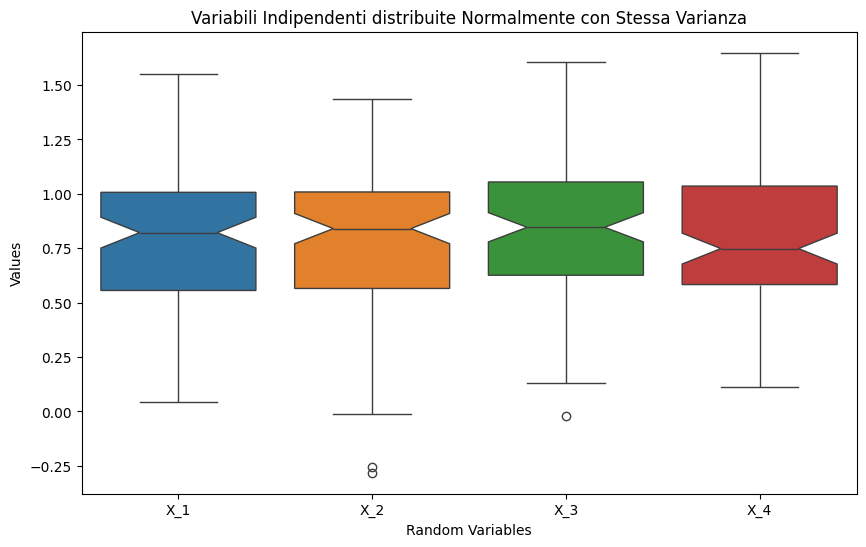

In [26]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df.drop(columns=['Index']), notch=True)

plt.title("Variabili Indipendenti distribuite Normalmente con Stessa Varianza")
plt.xlabel("Random Variables")
plt.ylabel("Values")
plt.show()

In [27]:
df.drop(columns=['Index']).describe()

,X_1,X_2,X_3,X_4
count,100.000000,100.000000,100.000000,100.000000
mean,0.791790,0.782639,0.829316,0.802692
std,0.331912,0.335075,0.327502,0.350614
min,0.043293,-0.281425,-0.022263,0.114507
25%,0.555926,0.565193,0.625905,0.583083
50%,0.821644,0.840238,0.846239,0.748333
75%,1.006917,1.008533,1.054503,1.035575
max,1.551541,1.433671,1.605139,1.648295


In [28]:
ANOVA_tbl = pd.melt(df, id_vars = ['Index'], var_name ='Group', value_name ='Value')
ANOVA_tbl = ANOVA_tbl.sort_values(by = ['Index', 'Group'])
ANOVA_tbl = ANOVA_tbl.reset_index(drop = True)
ANOVA_tbl

,Index,Group,Value
0,1,X_1,1.247792
1,1,X_2,0.494540
2,1,X_3,0.340785
3,1,X_4,0.262189
4,2,X_1,0.844625
...,...,...,...
395,99,X_4,0.561629
396,100,X_1,0.558313
397,100,X_2,1.255318
398,100,X_3,1.082406


In [29]:
# calcolo statistiche di gruppo dal file tbble
group_stats = ANOVA_tbl.groupby('Group').agg(
    count=('Value', 'count'),
    mean=('Value', 'mean'),
    sd=('Value', 'std')
).reset_index()

alpha = 0.01

# calcolo std err e limiti di confidenza usando la ppf
group_stats['std_err'] = group_stats['sd'] / np.sqrt(group_stats['count'])
group_stats['ci_lower'] = group_stats['mean'] - t.ppf(1 - alpha / 2, group_stats['count'] - 1) * group_stats['std_err']
group_stats['ci_upper'] = group_stats['mean'] + t.ppf(1 - alpha / 2, group_stats['count'] - 1) * group_stats['std_err']


group_stats


,Group,count,mean,sd,std_err,ci_lower,ci_upper
0,X_1,100,0.791790,0.331912,0.033191,0.704617,0.878964
1,X_2,100,0.782639,0.335075,0.033507,0.694635,0.870643
2,X_3,100,0.829316,0.327502,0.032750,0.743301,0.915332
3,X_4,100,0.802692,0.350614,0.035061,0.710606,0.894777


In [30]:
anova_result = smf.ols('Value ~ Group', data=ANOVA_tbl).fit()
anova_table = sm.stats.anova_lm(anova_result)

anova_table

,df,sum_sq,mean_sq,F,PR(>F)
Group,3.0,0.122514,0.040838,0.360898,0.781281
Residual,396.0,44.810209,0.113157,NaN,NaN


In [31]:
tukey_res = pairwise_tukeyhsd(ANOVA_tbl['Value'], ANOVA_tbl['Group'], alpha = 0.01)

tukey_res.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
X_1,X_2,-0.0092,0.9975,-0.1582,0.1399,False
X_1,X_3,0.0375,0.8595,-0.1115,0.1866,False
X_1,X_4,0.0109,0.9958,-0.1382,0.16,False
X_2,X_3,0.0467,0.7603,-0.1024,0.1957,False
X_2,X_4,0.0201,0.9748,-0.129,0.1691,False
X_3,X_4,-0.0266,0.9439,-0.1757,0.1224,False


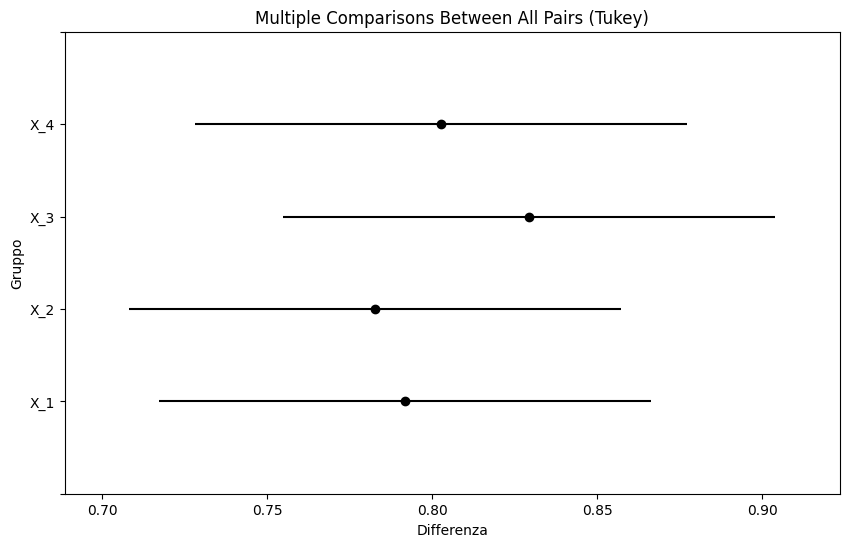

In [32]:
tukey_res.plot_simultaneous(ylabel = "Gruppo", xlabel = "Differenza")
plt.show()

In [33]:
SSb = anova_table.loc['Group', 'sum_sq']

df_between = anova_table.loc['Group', 'df']

# Verifica della distribuzione chi-quadro
p_value_between = chi2.sf(SSb, df_between)

print(f"SSb: {SSb}, df_between: {df_between}, p_value_between: {p_value_between}")

if p_value_between > alpha:
    print(f"\033[1mNon possiamo rigettare l'ipotesi nulla -> SSb segue una distribuzione chi-quadro con i corretti gradi di libertà. \033[0m")
else:
    print(f"\033[1mPossiamo rigettare l'ipotesi nulla -> SSb non segue una distribuzione chi-quadro con i corretti gradi di libertà. \033[0m")


SSb: 0.12251449729223945, df_between: 3.0, p_value_between: 0.9890050364520492
Non possiamo rigettare l'ipotesi nulla -> SSb segue una distribuzione chi-quadro con i corretti gradi di libertà. 
